#### Import / Global Vars

In [34]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [36]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy-sectors OR 'ark-etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
frequency = "W-THU" # initial value for lookback
lb = 60; min_gross=0.5; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

#### Load sector components from hard-drive

In [37]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


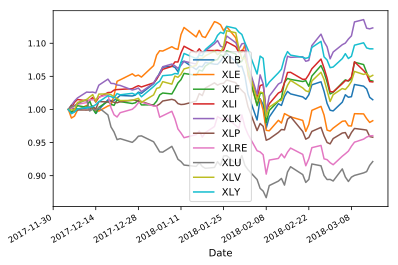

In [38]:
compound(px_etfs).plot(fontsize='small') # exclude from long strat the negative sectors?

#### Get Data from the Server

In [39]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universe + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

In [40]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (69, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (69, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (69, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (69, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (69, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (69, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (69, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (69, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (69, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (69, 33)


#### Generate Trading Recomendations

In [43]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px=consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px[consol_px.columns[:10]].tail(5)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI
Date,,,,,,,,,,
2018-03-09,71.129997,56.070000,118.860001,179.979996,119.290001,99.000000,63.599998,161.509995,221.110001,94.730003
2018-03-12,70.709999,56.500000,118.410004,181.720001,118.300003,100.290001,63.619999,161.690002,220.940002,95.529999
2018-03-13,70.680000,56.230000,119.000000,179.970001,119.750000,100.599998,63.200001,162.490005,219.759995,94.660004
2018-03-14,69.919998,55.279999,117.059998,178.440002,118.940002,98.580002,62.860001,161.000000,218.440002,94.089996
2018-03-15,70.230003,55.000000,117.050003,179.330002,116.221001,97.557503,62.785000,161.990005,219.210007,93.820000


In [45]:
# range of potential gammas using logspace
SAMPLES = 100; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
%time gamma_val, gamma_sr = quick_gamma(gamma_vals, consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w)
gamma_val, gamma_sr

CPU times: user 30.8 s, sys: 2.43 s, total: 33.3 s
Wall time: 19.1 s


(19.179102616724887, 1.7655021790336174)

In [46]:
# Creates matrix of lookbacks and weights to determine the best combination
lbs = [x for x in range(5, 60, 5)]
ws = [y/100 for y in [x for x in range(5, 20, 5)]]

mtx_cols = ["Lookback", "Weight", "Return", "Risk", "Sharpe"]
mtx_df = pd.DataFrame([], index=range(len(lbs) * len(ws)), columns=mtx_cols)

log = True; i = 0
for l in lbs:
    for w in ws:
        px_portion, _, alloc, _ = recommend_allocs(
            consol_px, hist_window, l, frequency, min_gross, max_gross, min_w, w, gamma_val)
        rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
        ret, risk = port_metrics(px_portion, rec)
        mtx_df.loc[i][mtx_cols] = [l, w, ret, risk, ret / risk]
        i += 1

In [47]:
mtx_df = mtx_df.sort_values(by='Return', ascending=False)
lb, max_w = mtx_df.iloc[0]['Lookback'], mtx_df.iloc[0]['Weight']
print("Gamma: {0:.2f}, Lookback: {1}, Max Weight: {2}".format(gamma_val, lb, max_w))

Gamma: 19.18, Lookback: 55, Max Weight: 0.05


In [48]:
# run optimization with best gamma, returns initial weights
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
tickers = rec.index.tolist()
recommend = rec.copy()
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
ADSK,0.018072,XLK,Autodesk Inc
AMZN,0.050000,XLY,Amazon.com Inc
CRM,0.050000,XLK,Salesforce.com
CTSH,0.050000,XLK,Cognizant Tech Solutions Corp
EA,0.048066,XLK,Electronic Arts
EL,0.050000,XLP,Estee Lauder Cos. A
EVHC,0.050000,XLV,Envision Healthcare Corp
EW,0.050000,XLV,Edwards Lifesciences Corp
FE,0.017217,XLU,FirstEnergy Corp
FISV,0.050000,XLK,Fiserv Inc


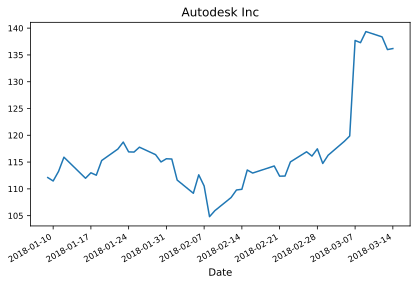

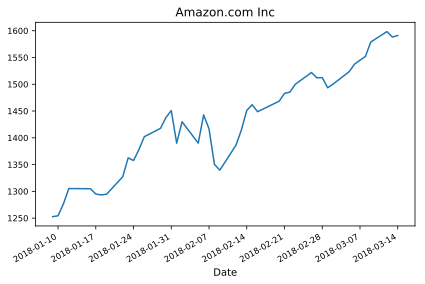

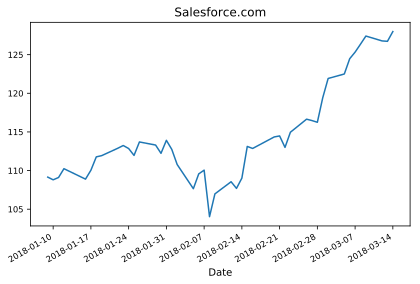

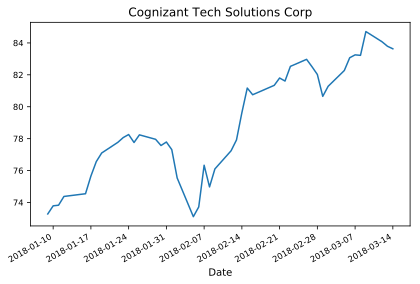

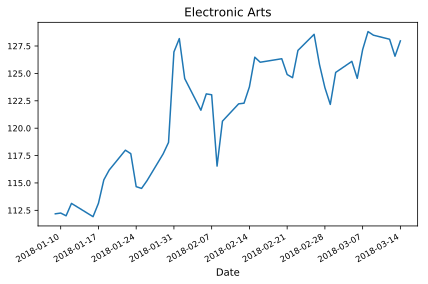

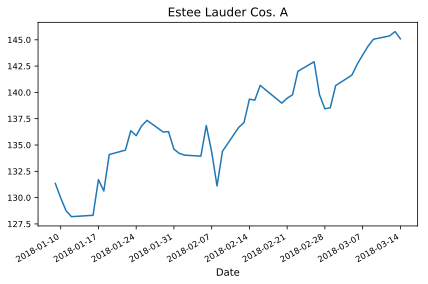

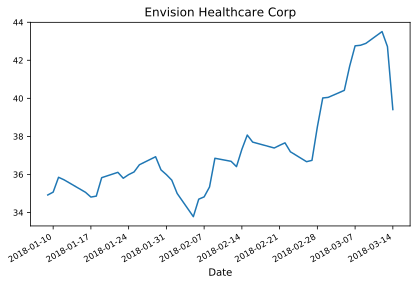

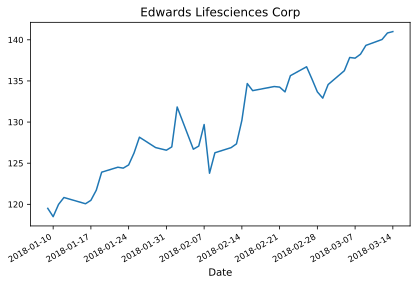

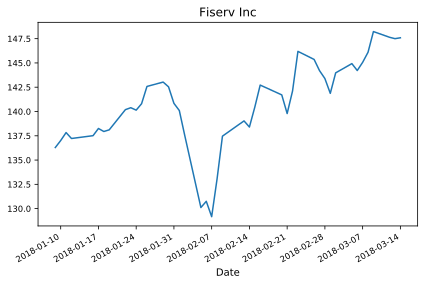

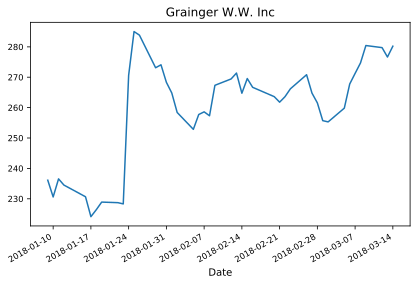

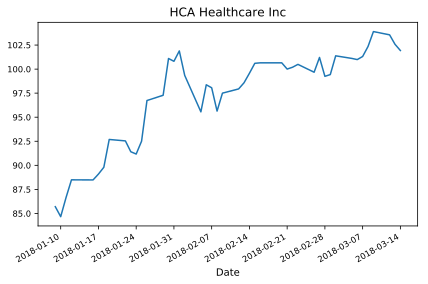

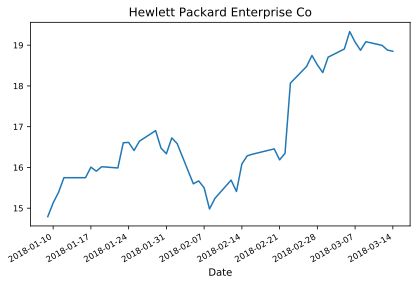

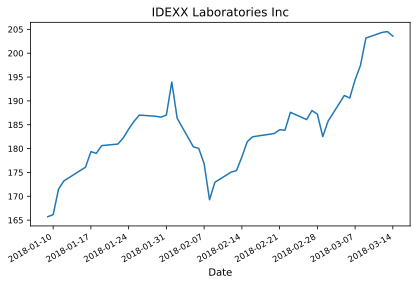

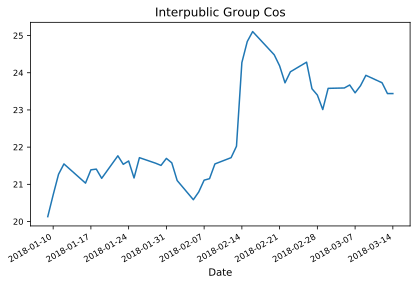

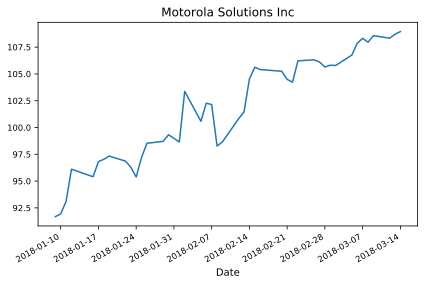

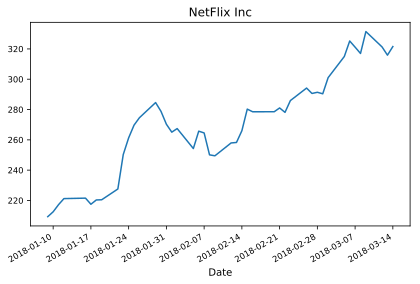

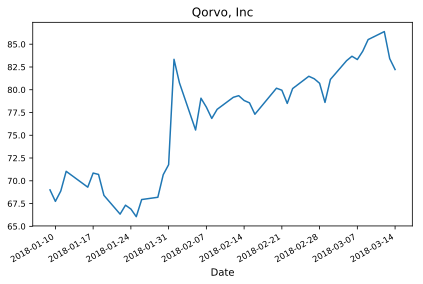

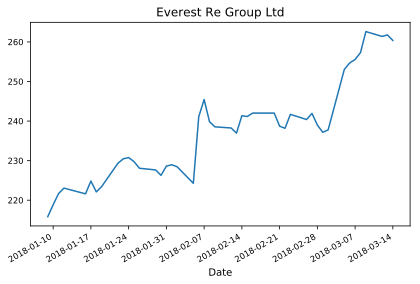

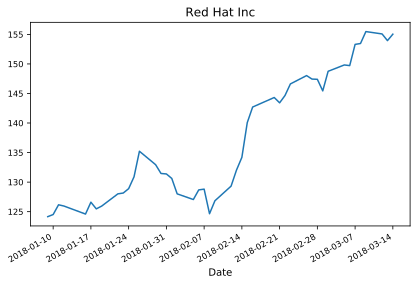

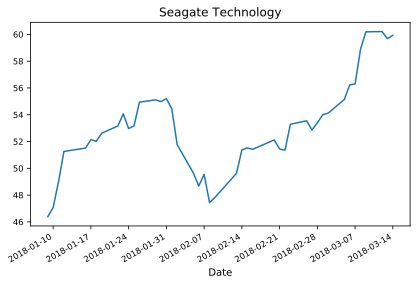

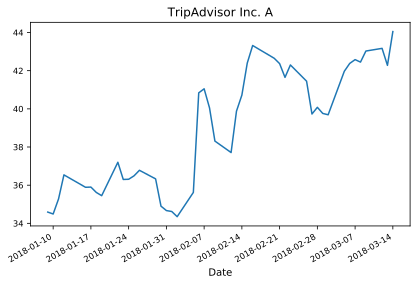

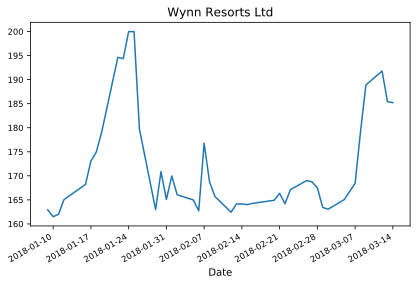

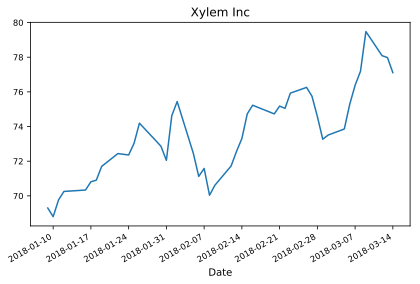

In [13]:
# plots all tickers to verify if there are any M&A targets
for t in recommend.sort_index().index:
    fig, ax = plt.subplots()
    plt.title(cos_no_dup.loc[t]['Company'])
    df_range = consol_px[t][-lb:]
    #dates = df_range.index.to_datetime()
    #values = df_range.values.tolist()
    #plt.plot(dates, values)
    #plt.xticks(np.arange(0, len(dates)), dates, rotation=45)
    fig.tight_layout()
    df_range.plot(fontsize='small')
    plt.show()

In [49]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 93.15


,Sector Weight,Avg Position
XLK,0.389436,0.043271
XLV,0.180949,0.036190
XLY,0.166354,0.041589
XLI,0.066150,0.033075
XLP,0.050000,0.050000
XLF,0.044802,0.044802
XLU,0.017217,0.017217
XLB,0.016605,0.016605


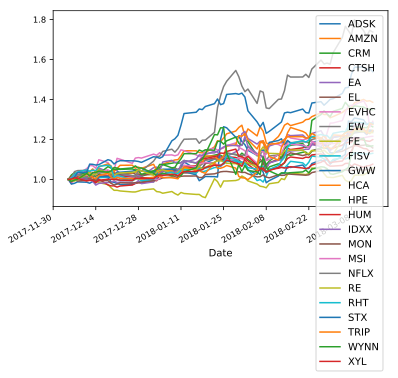

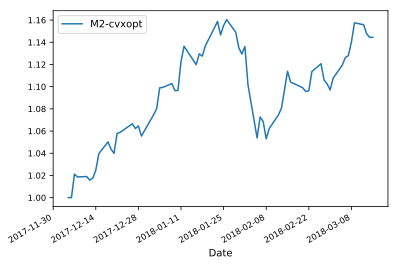

In [50]:
compound(consol_px[recommend.index][-hist_window:]).plot(fontsize='small')
pdf.plot(fontsize='small')

In [16]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 231000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.to_csv(universe+"-trading-df.csv")
trading_df.sort_index()


Time Window: 100, Lookback: 45, MinGross: 0.5, MaxGross: 1, MinWeight: 0, MaxWeight: 0.05
Ann. Ret: 0.09, Risk: 0.05 Sharpe: 1.88
Date: 2018-03-14, Total Invested: 231000.00, Total Allocation: 100.00%


,Company,Price,Allocation,Dollar Value,Shares
ADSK,Autodesk Inc,136.190002,0.041885,9675,71
AMZN,Amazon.com Inc,1591.000000,0.050000,11549,7
CRM,Salesforce.com,127.989998,0.050000,11549,90
CTSH,Cognizant Tech Solutions Corp,83.629997,0.050000,11549,138
EA,Electronic Arts,127.970001,0.029648,6848,53
EL,Estee Lauder Cos. A,145.089996,0.050000,11549,79
EVHC,Envision Healthcare Corp,39.410000,0.050000,11549,293
EW,Edwards Lifesciences Corp,141.000000,0.050000,11549,81
FISV,Fiserv Inc,147.589996,0.050000,11549,78
GWW,Grainger W.W. Inc,280.209991,0.050000,11549,41
